# Датасет для классификации ношения СИЗ

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import random
import shutil
import typing as tp

from pydantic import BaseModel
import datumaro as dm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ppe_modelling.utils import system_info_banner
from ppe_modelling.logger import logger

/home/quakumei/.pyenv/versions/3.10.12/lib/python3.10/importlib/util.py:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)
/home/quakumei/.pyenv/versions/ppe-modelling/lib/python3.10/site-packages/pyemd/__init__.py:74: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from .emd import emd, emd_with_flow, emd_samples
/home/quakumei/.pyenv/versions/ppe-modelling/lib/python3.10/site-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/quakumei/.pyenv/versions/ppe

## System Info

In [3]:
logger.info(system_info_banner())

[ppe-modelling] 17.04.2025 04:06:11 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [4]:
class PPEClassificationDatasetSettings(BaseModel):
    construction_ds_dir: Path = '../data/construction-site-safety-image-dataset-roboflow-coco-apr-6'
    out_path: Path = '../data/ppe_classification_dataset'

settings = PPEClassificationDatasetSettings()


## Import datasets

In [5]:
# construction
ds_construction = dm.Dataset.import_from(settings.construction_ds_dir, "coco_instances")
ds_construction

Dataset
	size=2801
	source_path=../data/construction-site-safety-image-dataset-roboflow-coco-apr-6
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.bbox: 6>}
	annotated_items_count=2777
	annotations_count=38352
subsets
	test: # of items=82, # of annotated items=74, # of annotations=760
	train: # of items=2605, # of annotated items=2599, # of annotations=36895
	val: # of items=114, # of annotated items=104, # of annotations=697
infos
	categories
	label: ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

## Inspect

/tmp/ipykernel_73122/329675036.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


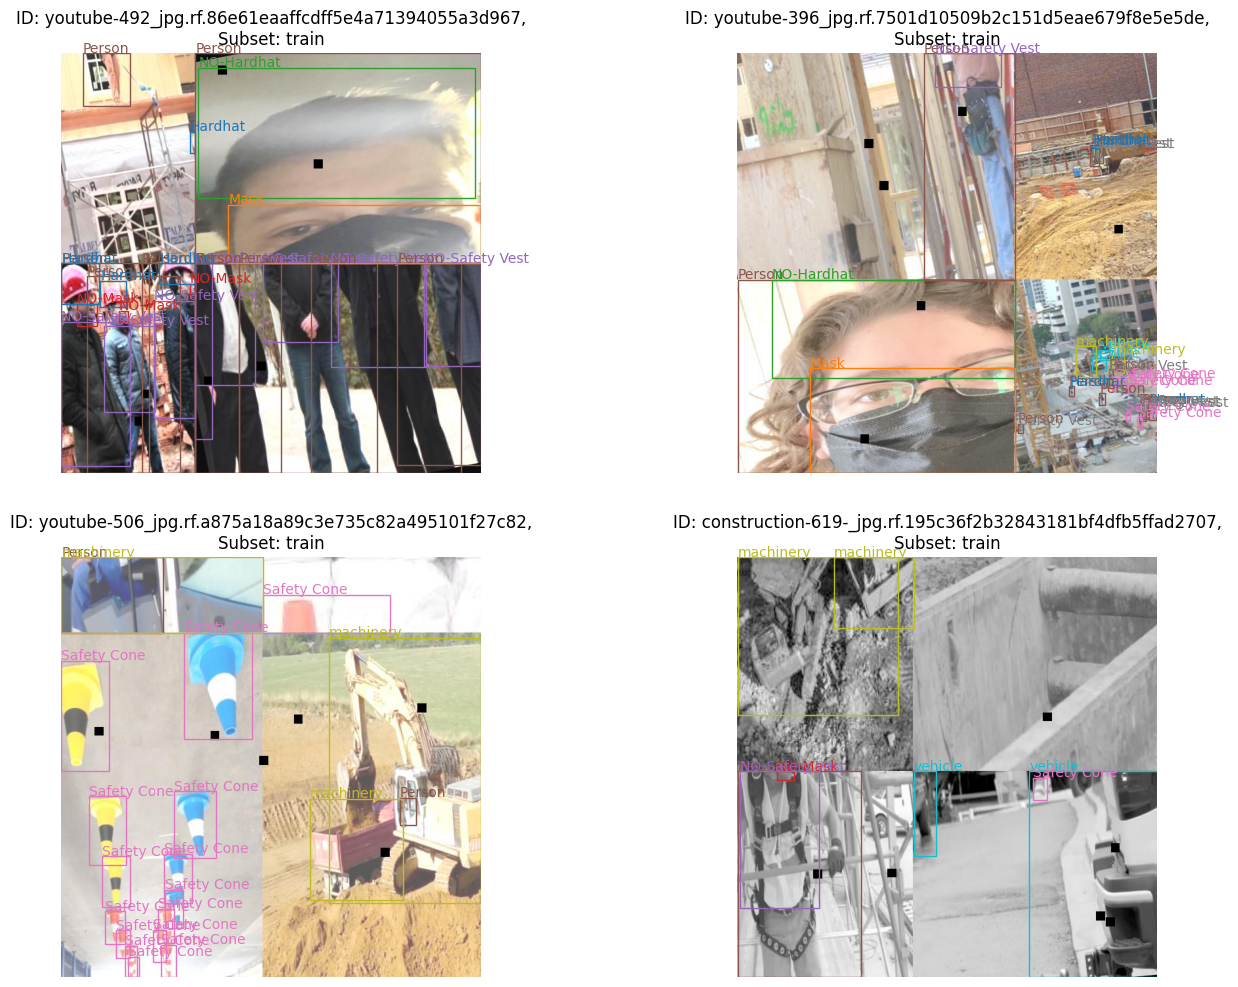

In [6]:
def get_ids(dataset: dm.Dataset, subset: str):
    ids = []
    for item in dataset:
        if item.subset == subset:
            ids += [item.id]

    return ids

def inspect_ds(dataset: dm.Dataset, subset: str = "train"):
    subset = 'train'
    ids = get_ids(dataset, subset)
    visualizer = dm.Visualizer(dataset, figsize=(16, 12), alpha=0.7)
    fig = visualizer.vis_gallery(random.sample(ids, 4), subset, grid_size=(None, None))
    fig.show()

inspect_ds(ds_construction)

## Idea

Необходимо ассоциировать разметку СИЗ с человеком.

Будем делать это, находя центры СИЗов. Если центр СИЗ внутри человека - на человеке надет СИЗ. Конечно, такой метод подвержен ложным срабатываниям. По крайней мере, в большинстве случаев это даст нам правильный статус СИЗ на человеке.

In [7]:
from typing import Tuple

def iou(bbox_xywh_1: Tuple[float, float, float, float],
        bbox_xywh_2: Tuple[float, float, float, float]) -> float:
    x1, y1, w1, h1 = bbox_xywh_1
    x2, y2, w2, h2 = bbox_xywh_2

    # Convert (x, y, w, h) to (x_min, y_min, x_max, y_max)
    x1_min, y1_min = x1 - w1 / 2, y1 - h1 / 2
    x1_max, y1_max = x1 + w1 / 2, y1 + h1 / 2
    x2_min, y2_min = x2 - w2 / 2, y2 - h2 / 2
    x2_max, y2_max = x2 + w2 / 2, y2 + h2 / 2

    # Intersection rectangle
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_w = max(0.0, inter_x_max - inter_x_min)
    inter_h = max(0.0, inter_y_max - inter_y_min)
    inter_area = inter_w * inter_h

    area_1 = w1 * h1
    area_2 = w2 * h2
    union_area = area_1 + area_2 - inter_area

    if union_area == 0:
        return 0.0

    return inter_area / union_area

DEFAULT_VAL = None

def get_person_ppe_state_from_annotation(person_ann: dm.Annotation, anns: tp.List[dm.Annotation], index_to_name: dict) -> dict:
    person_bbox = person_ann.get_bbox()
    ppe_set = {'Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Safety Vest'}
    ppe_anns = [ann for ann in anns if index_to_name[ann.label] in ppe_set]
    ppe_anns_with_iou = [(iou(person_bbox, ppe_ann.get_bbox()), index_to_name[ppe_ann.label]) for ppe_ann in ppe_anns]
    ppe_anns_with_iou_sorted = sorted(ppe_anns_with_iou, key=lambda x: x[0])
    ppe_state = {"Safety Vest": DEFAULT_VAL, "Hardhat": DEFAULT_VAL, "Mask": DEFAULT_VAL}
    for iou_value, ppe_ann in ppe_anns_with_iou_sorted:
        if iou_value < 0.005:
            continue
        if ppe_ann.startswith("NO-"):
            ppe_name = ppe_ann.split('NO-')[1]
            ppe_state[ppe_name] = False
        else:
            ppe_name = ppe_ann
            ppe_state[ppe_name] = True
    return ppe_state

def get_ppe_person_crops_from_ds(ds: dm.Dataset, person_class: str = 'Person') -> tp.Iterable[dm.DatasetItem]:
    index_to_name = {v:k for k, v in ds.categories()[dm.AnnotationType.label]._indices.items()}
    for item in ds:
        item_id = item.id
        anns = item.annotations
        person_anns = [ann for ann in anns if index_to_name[ann.label] == person_class]
        for person_i, person_ann in enumerate(person_anns):
            ppe_state = get_person_ppe_state_from_annotation(person_ann, anns, index_to_name)
            bbox_xywh=tuple(map(int, person_ann.get_bbox()))
            new_id = f"{item_id}_{person_i}_helmet{ppe_state['Hardhat']}_vest{ppe_state['Safety Vest']}"
            new_ds_item = dm.DatasetItem(
                id=new_id,
                media=dm.components.media.RoIImageFromFile(path=item.media.path, roi=bbox_xywh),
                subset=item.subset,
                annotations=[dm.Label(0, attributes=ppe_state)]
            )
            yield new_ds_item

def crop_ppe_persons(ds: dm.Dataset) -> dm.Dataset:
    ds = ds.clone()
    crop_iterable = get_ppe_person_crops_from_ds(ds)
    crop_iterable = filter(lambda x: None not in [x.annotations[0].attributes.get(v, None) for v in ['Safety Vest', 'Hardhat']], get_ppe_person_crops_from_ds(ds))
    crop_iterable = filter(lambda x: True not in [dim < 30 for dim in x.media.size], crop_iterable)
    crop_ds = dm.Dataset.from_iterable(crop_iterable)
    return crop_ds

ds_crop_ppe_persons = crop_ppe_persons(ds_construction)
ds_crop_ppe_persons

Dataset
	size=3728
	source_path=None
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.label: 1>}
	annotated_items_count=3728
	annotations_count=3728
subsets
	test: # of items=113, # of annotated items=113, # of annotations=113
	train: # of items=3511, # of annotated items=3511, # of annotations=3511
	val: # of items=104, # of annotated items=104, # of annotations=104
infos
	categories
	

/tmp/ipykernel_73122/329675036.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


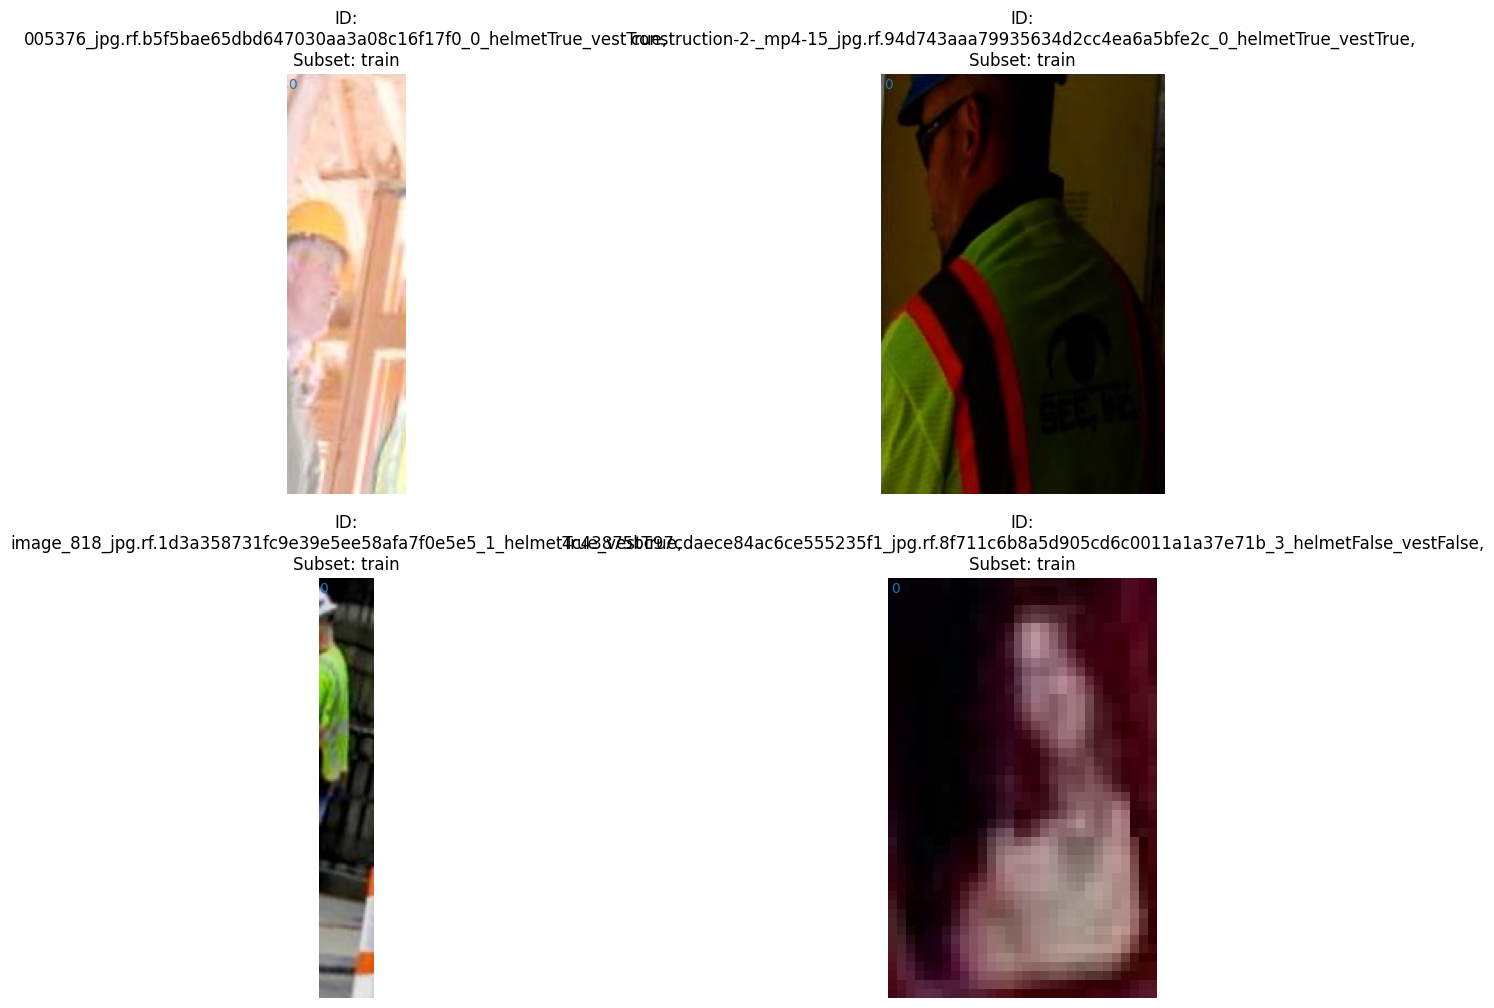

In [8]:
inspect_ds(ds_crop_ppe_persons)

## Inspect data

In [9]:
annotation_list = []
for item in tqdm(ds_crop_ppe_persons):
    person_dict = {"id": item.id}
    person_dict.update(item.annotations[0].attributes)
    annotation_list.append(person_dict)

annotation_df = pd.DataFrame(data=annotation_list)
annotation_df = annotation_df.set_index('id')
annotation_df


100%|██████████| 3728/3728 [00:00<00:00, 242045.25it/s]


,Safety Vest,Hardhat,Mask
id,,,
004424_jpg.rf.0470713b945b08839105cde711db62d9_0_helmetTrue_vestFalse,False,True,False
-3154-_png_jpg.rf.f118da2b1c20afb78ff93dc7d558f42c_0_helmetTrue_vestFalse,False,True,False
youtube-392_jpg.rf.7e49e3a8486caaa4e9d82246de93e68e_0_helmetTrue_vestTrue,True,True,None
youtube-455_jpg.rf.35acd2e91608806a26f3ac4e784ea512_0_helmetTrue_vestTrue,True,True,False
youtube-455_jpg.rf.35acd2e91608806a26f3ac4e784ea512_1_helmetTrue_vestTrue,True,True,None
...,...,...,...
youtube-636_jpg.rf.623eb323389f62bea29c28bd49793022_1_helmetFalse_vestFalse,False,False,True
youtube-636_jpg.rf.623eb323389f62bea29c28bd49793022_2_helmetTrue_vestTrue,True,True,None
youtube-57_jpg.rf.ea273bcf5a2ff4438d449ffa5a2db852_0_helmetFalse_vestFalse,False,False,True


In [10]:
annotation_df[['Safety Vest', 'Hardhat']].value_counts(dropna=False)

Safety Vest  Hardhat
True         True       1453
False        False      1215
             True        912
True         False       148
Name: count, dtype: int64

In [13]:
# Remove None's for simplicity
annotation_df[['Safety Vest', 'Hardhat']].value_counts(dropna=True).sort_index(ascending=False)

Safety Vest  Hardhat
True         True       1453
             False       148
False        True        912
             False      1215
Name: count, dtype: int64

Processing dataset with 3728 items


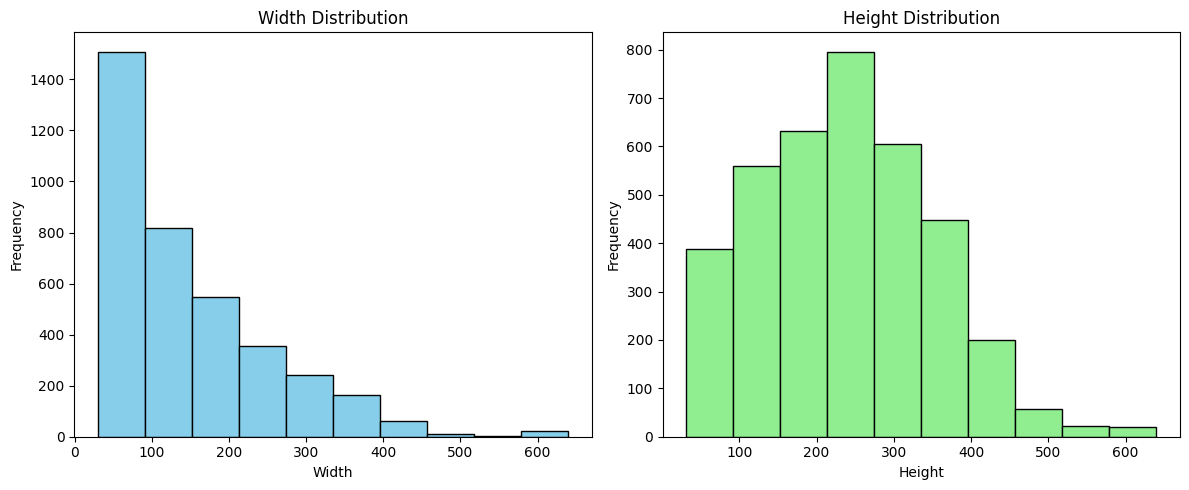

{'widths': {'min': 30, 'max': 640, 'mean': 145.59146995708156, 'percentiles': {'25th': 63.0, '50th': 113.0, '75th': 201.25}}, 'heights': {'min': 31, 'max': 640, 'mean': 238.58369098712447, 'percentiles': {'25th': 151.0, '50th': 234.0, '75th': 314.0}}}


In [43]:
def get_size_stats(dataset, verbose=True):
    ws = []  # List for widths
    hs = []  # List for heights
    for i in range(len(dataset)):
        wh = dataset[i].media.roi[-2:]  # Get last two elements (width, height)
        ws.append(wh[0])  # Width
        hs.append(wh[1])  # Height

    # Calculate statistics
    stats_dict = {
        'widths': {
            'min': min(ws),
            'max': max(ws),
            'mean': np.mean(ws),
            'percentiles': {
                '25th': np.percentile(ws, 25),
                '50th': np.percentile(ws, 50),  # Median
                '75th': np.percentile(ws, 75)
            }
        },
        'heights': {
            'min': min(hs),
            'max': max(hs),
            'mean': np.mean(hs),
            'percentiles': {
                '25th': np.percentile(hs, 25),
                '50th': np.percentile(hs, 50),  # Median
                '75th': np.percentile(hs, 75)
            }
        }
    }

    if verbose:
        print("Processing dataset with", len(dataset), "items")

    # Plot histograms
    plt.figure(figsize=(12, 5))

    # Widths histogram
    plt.subplot(1, 2, 1)
    plt.hist(ws, bins=10, color='skyblue', edgecolor='black')
    plt.title('Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    # Heights histogram
    plt.subplot(1, 2, 2)
    plt.hist(hs, bins=10, color='lightgreen', edgecolor='black')
    plt.title('Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return stats_dict

stats_dict = get_size_stats(ds_crop_ppe_persons)
print(stats_dict)

## Export dataset

In [44]:
def export_ds_to_datumaro(ds: dm.Dataset, path: str | Path):
    path = str(path)
    if Path(path).exists():
        shutil.rmtree(path)
    format = 'datumaro'
    ds.export(
        path,
        format,
        progress_reporter=dm.TQDMProgressReporter(period=1),
        save_media=True
    )
    print(f"Exported dataset to {path} in '{format}' format sucessfully!")

export_ds_to_datumaro(ds_crop_ppe_persons, settings.out_path)

Exporting 'val':   0%|          | 0/104 [00:00<?, ?it/s]

Exporting 'test':   0%|          | 0/113 [00:00<?, ?it/s]

Exporting 'train':   0%|          | 0/3511 [00:00<?, ?it/s]

Exported dataset to ../data/ppe_classification_dataset in 'datumaro' format sucessfully!
